# Get Kickers data by Game from DB

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.mlab as mlab
from mysql.connector import errorcode
import matplotlib.pyplot as plt

%matplotlib inline

config = {
'user': 'db_gtown_2018',
'password': 'Gtown2018',
'port': '3306',
'host': 'nflnumbers.czuayagz62va.us-east-1.rds.amazonaws.com',
'database': 'db_nfl',
'raise_on_warnings': True,
}
 
try:
    cnx = mysql.connector.connect(**config)
    cursor = cnx.cursor()
    #Let's read all the rows in the table
    readContactPerson = """SELECT 
    FGXP,FKICKER,Percentage.GID,
    ((SUM(SUCCESS) / COUNT(*)) * 100) AS SUCCESS_PERCENTAGE,
    SUM(SUCCESS) AS SUCCESS_COUNT,
    SUM(BLOCKED) AS BLOCKED_COUNT,
    SUM(HIGH_PRESSURE) AS HIGH_PRESSURE_COUNT,
    COUNT(*) AS COUNT,
    TEMP, HUMD, WSPD, COND, SURF,
    (YEAR(CURDATE()) - PLAYER.start) AS YEARS_PLAYED,height,weight,
	PLAYER.forty,PLAYER.bench,PLAYER.vertical,PLAYER.broad,PLAYER.shuttle,PLAYER.cone,
	PLAYER.arm,PLAYER.hand,PLAYER.dcp,
    DPOS AS DRAFT_POSITION,
    (SELECT 
            (TO_DAYS(NOW()) - TO_DAYS(STR_TO_DATE(dob, '%m/%d/%Y'))) / 365
        FROM
            PLAYER P
        WHERE
            P.player = FKICKER) AS AGE_YEARS
FROM
    (SELECT FGXP,PBP.GID,PBP.FKICKER,
            DIST,QTR,MIN,TIMO AS TIMO_REMAIN,
            CASE 
                WHEN GOOD = 'Y' THEN 1
                ELSE 0
            END AS SUCCESS,
            CASE
                WHEN UPPER(DETAIL) LIKE '%BLOCKED%' THEN 1
                ELSE 0
            END AS BLOCKED,
            DIST - (100 - CASE
                WHEN YFOG = '' THEN '98'
                ELSE YFOG
            END) AS YDS_BEHIND_LOS,
            PTSO - PTSD AS POINT_DIFFERENTIAL,
            CASE
                WHEN
                    QTR IN ('2' , '4') AND MIN <= 2
                        AND (PTSO - PTSD) >= - 3
                THEN
                    1
                ELSE 0
            END AS HIGH_PRESSURE
    FROM
        PBP
    LEFT OUTER JOIN PLAYER PLAYER ON PBP.FKICKER = PLAYER.PLAYER
    WHERE
        TYPE = 'FGXP' AND POS1='K') AS Percentage
        LEFT OUTER JOIN
    PLAYER PLAYER ON Percentage.FKICKER = PLAYER.PLAYER
        LEFT OUTER JOIN
    GAME ON Percentage.GID = GAME.GID
    WHERE FGXP='FG'
GROUP BY FKICKER , Percentage.GID
ORDER BY FKICKER , Percentage.GID;"""
    cursor.execute(readContactPerson)
    #specify the attributes that you want to display
    df = DataFrame(cursor.fetchall())    
    
    cnx.commit()
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    cursor.close()
    cnx.close()

In [2]:
df.columns = ['FGXP','FKICKER','GID','SUCCESS_PERCENTAGE','SUCCESS_COUNT','BLOCKED_COUNT','HIGH_PRESSURE_COUNT','COUNT','TEMP','HUMD','WSPD','COND','SURF',
             'YEARS_PLAYED','height','weight',
             'forty','bench','vertical','broad','shuttle','cone',
             'arm','hand','dcp','DRAFT_POSITION','AGE_YEARS']

In [3]:
df.head(3)

,FGXP,FKICKER,GID,SUCCESS_PERCENTAGE,SUCCESS_COUNT,BLOCKED_COUNT,HIGH_PRESSURE_COUNT,COUNT,TEMP,HUMD,...,bench,vertical,broad,shuttle,cone,arm,hand,dcp,DRAFT_POSITION,AGE_YEARS
0,FG,AD-0800,14,100.0000,2,0,0,2,73,78,...,0,0.0,0,0.0,0.0,0,0.0,0,0,56.1945
1,FG,AD-0800,28,100.0000,1,0,0,1,80,84,...,0,0.0,0,0.0,0.0,0,0.0,0,0,56.1945
2,FG,AD-0800,54,100.0000,3,0,0,3,61,0,...,0,0.0,0,0.0,0.0,0,0.0,0,0,56.1945


## Weather conditions

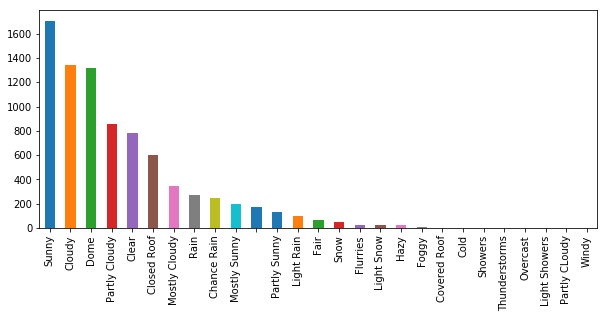

In [4]:
plt.figure(figsize=(10,4))
df["COND"].value_counts().plot(kind='bar')

too many weather categories, lets group them

In [5]:
WeatherConditionsDifficultyLevel = {
    'unknown': '',
    'normal':['Closed Roof','Covered Roof','Dome','Clear','Cloudy',
              'Partly Cloudy','Mostly Cloudy','Fair','Partly CLoudy',
              'Sunny','Mostly Sunny','Partly Sunny'],
    'hard':['Chance Rain','Light Rain','Flurries','Light Snow','Light Showers'],
    'extreme':['Rain','Showers','Snow','Foggy','Hazy','Thunderstorms','Cold',
               'Windy','Overcast']
}

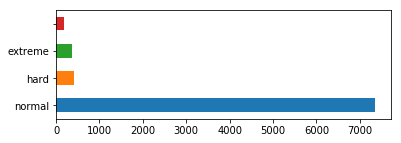

In [6]:
def multiple_replace(dict, text):
    for k,v in dict.items():        
        for val in dict[k]:
            if(val == text):
                return k
    return text
dfc = df.apply(lambda row: multiple_replace(WeatherConditionsDifficultyLevel, row['COND']), axis=1)
df["WeatherCondition"] = dfc
plt.figure(figsize=(6,2))
df["WeatherCondition"].value_counts().plot(kind='barh')

Let's see wheather effect on success counts

In [7]:
ddf = pd.DataFrame(df.groupby(['WeatherCondition'])['BLOCKED_COUNT','SUCCESS_COUNT','COUNT'].sum())

In [8]:
ddf['%']=(ddf['SUCCESS_COUNT']/ddf['COUNT'])*100

KeyError: 'SUCCESS_COUNT'

In [ ]:
ddf

In [ ]:
ddf.boxplot

## SURF

In [ ]:
df["SURF"].value_counts().plot(kind='barh')

In [ ]:
df.groupby(['FKICKER','SURF'])['SUCCESS_COUNT','COUNT'].sum()

In [ ]:
df["YEARS_PLAYED"].describe()

## Find correlation amoung all columns

In [9]:
df[['SUCCESS_PERCENTAGE','SUCCESS_COUNT','BLOCKED_COUNT','HIGH_PRESSURE_COUNT','COUNT','TEMP','HUMD','WSPD','YEARS_PLAYED','height','weight','forty','bench','vertical','broad','shuttle','cone','arm','hand','dcp','DRAFT_POSITION','AGE_YEARS']]=df[['SUCCESS_PERCENTAGE','SUCCESS_COUNT','BLOCKED_COUNT','HIGH_PRESSURE_COUNT','COUNT','TEMP','HUMD','WSPD','YEARS_PLAYED','height','weight','forty','bench','vertical','broad','shuttle','cone','arm','hand','dcp','DRAFT_POSITION','AGE_YEARS']].apply(pd.to_numeric)

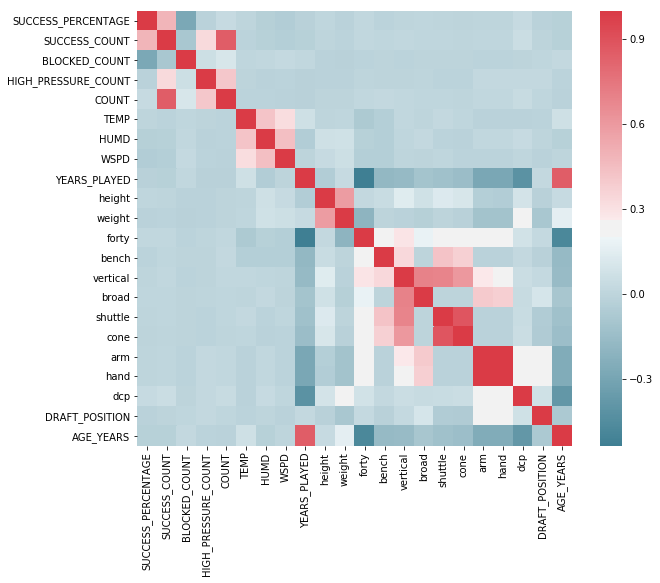

In [10]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
corr_matrix = df.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var